In [1]:
import copy
import os
import pandas as pd
import math
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set(style="white", color_codes=True)
import json
from sklearn.metrics import mean_squared_error
%matplotlib inline



In [2]:
def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_original = getDF('/home/kapil/SJSU Acad/SJSU 2nd Sem/256 Wu/CMPE-256/E-commerce-recommedation-system/Data/Beauty_5.json')

In [3]:
df=copy.deepcopy(df_original)
df['unixReviewTime']=pd.to_datetime(df['unixReviewTime'],unit='s')
df.drop(['reviewTime'],axis=1,inplace=True)
# set unique ID for each review
df['ReviewID']=df.index+1

In [4]:
n_users = df.reviewerID.unique().shape[0]
n_items = df.asin.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')


22363 users
12101 items


In [9]:
df = df.sort_values(['reviewerID', 'asin'], ascending = [True, True])

df.asin=pd.Categorical(df.asin)
df['asin_id']=df.asin.cat.codes
df.reviewerID=pd.Categorical(df.reviewerID)
df['reviewer_ID']=df.reviewerID.cat.codes

In [10]:
print ("reviewer ",pd.DataFrame(df.groupby(['reviewer_ID'])['reviewerID'].nunique()).sort_values(['reviewerID'],ascending=False).shape[0])
print ("item ", pd.DataFrame(df.groupby(['asin_id'])['asin'].nunique()).sort_values(['asin'],ascending=False).shape[0])

reviewer  22363
item  12101


In [11]:
df.head()
df_ratings=df[['reviewer_ID','asin_id','overall']]
ratings = np.zeros((n_users, n_items))

for row in df_ratings.itertuples():
    #print (row[1],row[2],row[3])
    ratings[row[1], row[2]] = row[3]
    
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity = (sparsity/(ratings.shape[0] * ratings.shape[1]))*100
print ('Sparsity: {:4.2f}%'.format(sparsity))



Sparsity: 0.07%


In [13]:
min_rated_items=ratings.nonzero()[0]
min_rated_items_collection={}
for i in min_rated_items:
    if i in min_rated_items_collection:
        min_rated_items_collection[i]=min_rated_items_collection[i]+1
    else:
        min_rated_items_collection[i]=1

In [14]:
user_rate_count=sorted(min_rated_items_collection.items(),key=lambda x:x[1])
print ('User rated ',user_rate_count[-1][1], 'items at the most')
print ('User rated ',user_rate_count[0][1], 'items at the least')

User rated  204 items at the most
User rated  5 items at the least


In [15]:
min_rate_by_users=ratings.nonzero()[1]
min_rate_by_users_collection={}
for i in min_rate_by_users:
    if i in min_rate_by_users_collection:
        min_rate_by_users_collection[i]=min_rate_by_users_collection[i]+1
    else:
        min_rate_by_users_collection[i]=1

In [16]:
item_rate_count=sorted(min_rate_by_users_collection.items(),key=lambda x:x[1])
print ('Item rated by ',item_rate_count[-1][1], ' users at the most')
print ('Item rated by ',item_rate_count[0][1], ' users at the least')

Item rated by  431  users at the most
Item rated by  5  users at the least


In [17]:
count_bin=np.linspace(10,100,10).tolist()
count_bin.extend([5,300,500])
array_rate_count=np.array(count_bin)
array_rate_count=np.sort(array_rate_count)

In [18]:
# get the user-rated item number distribution table
def to_category(row,colname='rated_items',cate=array_rate_count):
    first_arg=np.where(cate>=row[colname])[0][0]
    if first_arg!=0:
        return "("+str(int(cate[first_arg-1]))+", "+str(int(cate[first_arg]))+"]", cate[first_arg]
    else:
        return "(, "+str(int(cate[first_arg]))+"]", cate[first_arg]

item_count=pd.DataFrame.from_dict(min_rated_items_collection,orient='index')\
.reset_index().rename(columns={'index':'userID',0: 'rated_items'})
item_count['rated_items_cat'],item_count['rated_items_num']=zip(*item_count\
                                                                .apply(to_category,cate=array_rate_count,axis=1))
pd.DataFrame(item_count.groupby(['rated_items_cat'])['userID'].count()).reset_index()

,rated_items_cat,userID
0,"(, 5]",7162
1,"(10, 20]",3106
2,"(100, 300]",17
3,"(20, 30]",655
4,"(30, 40]",231
5,"(40, 50]",97
6,"(5, 10]",10959
7,"(50, 60]",62
8,"(60, 70]",23
9,"(70, 80]",26


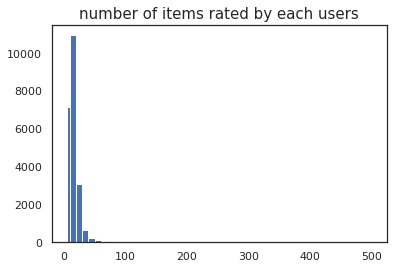

In [19]:
plt.hist(item_count['rated_items_num'],array_rate_count)
plt.title('number of items rated by each users', fontsize=15)
plt.show()

In [20]:
# get the item rated by the number of users distribution table
user_count=pd.DataFrame.from_dict(min_rate_by_users_collection,orient='index')\
.reset_index().rename(columns={'index':'itemID',0: 'rated_by_users'})
user_count['rated_by_user_cat'],user_count['rated_by_user_num']=zip(*user_count.apply(to_category,colname='rated_by_users',cate=array_rate_count,axis=1))
pd.DataFrame(user_count.groupby(['rated_by_user_cat'])['itemID'].count()).reset_index()



,rated_by_user_cat,itemID
0,"(, 5]",2181
1,"(10, 20]",2632
2,"(100, 300]",159
3,"(20, 30]",870
4,"(30, 40]",422
5,"(300, 500]",10
6,"(40, 50]",240
7,"(5, 10]",5031
8,"(50, 60]",181
9,"(60, 70]",138


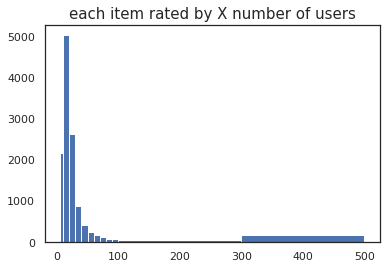

In [21]:
plt.hist(user_count['rated_by_user_num'],array_rate_count)
plt.title('each item rated by X number of users', fontsize=15)
plt.show()

In [22]:
# modify N-core to add the map between new position to old position
def apply_Ncore(ratings, N_core):
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    items_id = [x for x in range(n_items) if len(ratings[:, x].nonzero()[0]) >= N_core]
    ratings = ratings[:, items_id]
    # map the new items position to the old
    item_link=list(zip(items_id,range(ratings.shape[1])))
    users_id = [x for x in range(n_users) if len(ratings[x, :].nonzero()[0]) >= N_core]
    # map the new user posistion to the old
    ratings = ratings[users_id, :]
    user_link=list(zip(users_id,range(ratings.shape[0])))
    return ratings,item_link,user_link



In [23]:
ratings_Ncore,items_link_Ncore,users_link_Ncore = apply_Ncore(ratings, 8)

In [24]:
print("After applying the 10-core, there are", ratings_Ncore.shape[0], "users left")
print("After applying the 10-core, there are", ratings_Ncore.shape[1], "items left")
sparsity = float(len(ratings_Ncore.nonzero()[0]))
sparsity = (sparsity/(ratings_Ncore.shape[0] * ratings_Ncore.shape[1]))*100
print ('Sparsity: {:4.2f}%'.format(sparsity))


After applying the 10-core, there are 6172 users left
After applying the 10-core, there are 7129 items left
Sparsity: 0.20%


In [25]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,ReviewID,asin_id,reviewer_ID
145572,A00414041RD0BXM6WK0GX,B007IY97U0,Sarah Hale,"[0, 0]","Good quality wig, but the blonde is much more ...",3.0,Three Stars,2014-07-14,145573,9449,0
152551,A00414041RD0BXM6WK0GX,B00870XLDS,Sarah Hale,"[0, 0]",Very thin and not as long as the photos :( Aft...,2.0,( After waiting over a month to receive this w...,2014-07-14,152552,9839,0
155883,A00414041RD0BXM6WK0GX,B008MIRO88,Sarah Hale,"[0, 0]",Very thin and not as long as the photos :( Aft...,1.0,( After waiting over a month to receive this w...,2014-07-14,155884,10076,0
178477,A00414041RD0BXM6WK0GX,B00BQYYMN0,Sarah Hale,"[0, 0]","This is a great quality wig, however it is a m...",3.0,This is a great quality wig,2014-07-14,178478,11155,0
188781,A00414041RD0BXM6WK0GX,B00GRTQBTM,Sarah Hale,"[0, 0]",This is my absolute favorite wig! I have purch...,5.0,This is my absolute favorite wig! I have purch...,2014-07-14,188782,11752,0


In [26]:
df['reviewerID_Ncore']=df['reviewer_ID'].map(dict(users_link_Ncore))
df['asinID_Ncore']=df['asin_id'].map(dict(items_link_Ncore))
item_map_afterNcore=df[['asinID_Ncore','asin']].drop_duplicates(keep='first')
user_map_afterNcore=df[['reviewerID_Ncore','reviewerID']].drop_duplicates(keep='first')

In [27]:
user_map_afterNcore.loc[user_map_afterNcore['reviewerID_Ncore']==1]


,reviewerID_Ncore,reviewerID
22693,1.0,A03364251DGXSGA9PSR99


In [28]:
df.loc[df['reviewerID']=='A099766128UI0NCS98N1E',['reviewerID','asin','reviewer_ID','reviewerID_Ncore','asin_id','asinID_Ncore']]

,reviewerID,asin,reviewer_ID,reviewerID_Ncore,asin_id,asinID_Ncore
3539,A099766128UI0NCS98N1E,B00008MOQE,29,4.0,184,123.0
6806,A099766128UI0NCS98N1E,B0001TOH8G,29,4.0,359,237.0
11638,A099766128UI0NCS98N1E,B0007W1R58,29,4.0,687,440.0
42136,A099766128UI0NCS98N1E,B0012UEJ1S,29,4.0,2846,1644.0
66990,A099766128UI0NCS98N1E,B001YTD3G4,29,4.0,4562,2622.0
92722,A099766128UI0NCS98N1E,B003OIPJZ6,29,4.0,6250,3599.0
93742,A099766128UI0NCS98N1E,B003RF82UK,29,4.0,6310,3636.0
103137,A099766128UI0NCS98N1E,B0048KSGZO,29,4.0,6902,4001.0
103757,A099766128UI0NCS98N1E,B004AGM47C,29,4.0,6943,NaN
104465,A099766128UI0NCS98N1E,B004BCX8B6,29,4.0,6992,4056.0


In [29]:
def train_test_split_userwise(ratings,num_test=5):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    nonzero_id=np.transpose(np.array([ratings.nonzero()[0].tolist(),ratings.nonzero()[1].tolist()]))
    index=pd.DataFrame(nonzero_id,columns=['row','col'])
    gps =index.groupby(['row'])
    randx = lambda obj: obj.loc[np.random.choice(obj.index, num_test, False),:]
    test_ratings=gps.apply(randx).values.transpose()
    test_ratings_row=test_ratings[0].tolist()
    test_ratings_col=test_ratings[1].tolist()
    train[test_ratings_row,test_ratings_col] = 0.
    test[test_ratings_row,test_ratings_col] = ratings[test_ratings_row,test_ratings_col]   
    assert(np.all((train * test) == 0)) 
    return train, test

In [30]:
train_Ncore_user, test_Ncore_user = train_test_split_userwise(ratings_Ncore,num_test=3)
# check whether the test dataset has the same shape as the training
print('training dimension: ', train_Ncore_user.shape)
print('test dimension: ',test_Ncore_user.shape)

training dimension:  (6172, 7129)
test dimension:  (6172, 7129)


In [31]:
#user-wise
def normalize_userwise(train,test):
    user=0
    train_new=copy.deepcopy(train)
    test_new=copy.deepcopy(test)
    for i in range(train_new.shape[0]):
        items=np.nonzero(train_new[i,:])[0].tolist()
        user_avg=np.sum(train_new[i,items])/len(items)
        items_test=np.nonzero(test_new[i,:])[0].tolist()
        train_new[i,items]=(train_new[i,items]-user_avg)
        test_new[i,items_test]=(test_new[i,items_test]-user_avg)
    return train_new, test_new

In [32]:
train_Ncore_user_normalized,test_Ncore_user_normalized=normalize_userwise(train_Ncore_user,test_Ncore_user)


In [33]:
# check for the output of normaization
# user for 0 in training set
user_0_trainting_sum=np.sum(train_Ncore_user_normalized[1,[x[1] for x in \
                                       list(zip(np.nonzero(train_Ncore_user_normalized)[0],\
                                            np.nonzero(train_Ncore_user_normalized)[1])) if x[0]==1]])
print ('average ratings for user 0 in training after normalization: ', user_0_trainting_sum)

# user for 0 in test set
user_0_test_sum=np.sum(test_Ncore_user_normalized[1,[x[1] for x in \
                                       list(zip(np.nonzero(test_Ncore_user_normalized)[0],\
                                            np.nonzero(test_Ncore_user_normalized)[1])) if x[0]==1]])
print ('average ratings for user 0 in test after normalization: ',user_0_test_sum)



average ratings for user 0 in training after normalization:  -3.552713678800501e-15
average ratings for user 0 in test after normalization:  1.1499999999999995


In [34]:
def get_mse(pred, actual):
    pred = pred[actual.nonzero()[0].tolist(),actual.nonzero()[1].tolist()].flatten()
    actual = actual[actual.nonzero()[0].tolist(),actual.nonzero()[1].tolist()].flatten()
    mse = mean_squared_error(pred, actual)
    return mse



In [35]:
def user_baseline(train,test):
    user=0
    item_sum=0
    item_count=0
    pred=np.zeros(test.shape)
    for i in zip(np.nonzero(train)[0],np.nonzero(train)[1]):
        if i[0]==user:
            item_sum=train[i[0],i[1]]+item_sum
            item_count=item_count+1
        if i[0]>user:
            item_pos=np.nonzero(test[user,:])[0].tolist()
            pred[user,item_pos]=item_sum/item_count
            user=user+1
            item_sum=0
            item_count=0
            item_sum=train[i[0],i[1]]+item_sum
            item_count=item_count+1
    item_pos=np.nonzero(test[user,:])[0].tolist()
    pred[user,item_pos]=item_sum/item_count
    return pred



In [36]:
# baseline without normalization
# baseline MSE for Stochastic Gradient Descent
user_baseline_withoutN=user_baseline(train_Ncore_user,test_Ncore_user)
print ('baseline MSE without normalization: ', get_mse(user_baseline_withoutN,test_Ncore_user))



baseline MSE without normalization:  1.2166400132052315


In [37]:
# baseline with normalization
# baseline MSE for Alternating Least Square
user_baseline_normalized=np.sum(test_Ncore_user_normalized**2)/len(np.nonzero(test_Ncore_user)[0])
print ('baseline MSE with normalization: ', user_baseline_normalized)



baseline MSE with normalization:  1.216640013205234


In [38]:
class RecommendationSGD_Random():
    
    def __init__(self, 
                 ratings, 
                 n_factors = 10, 
                 item_reg = 1.0, 
                 user_reg = 1.0,
                 item_bias_reg = 1.0,
                 user_bias_reg = 1.0,
                 max_iter = 15,
                 batch_size=3,
                 learning_rate = 0.01,
                 tolerance=0.0001,
                 verbose = True):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        item_bias_reg : (float)
            Item bias for item latent factors, shape as number of items *1
        
        user_bias_reg : (float)
            User bias for user latent factors, shape as number of users *1
            
        max_iter: (int)
            Max number of epoch
        
        batch_size: (int)
            number of rows input each time to update the gradient
        
        learning_rate: (float)
            learning rate of latent factors and bias
        
        tolerance: (float)
            cut-off on iterations when percange change in loss function lower to the value
            
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning_rate = learning_rate
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self.batch_size=batch_size
        self._v = verbose
        self.n_iter = max_iter
        self.MSE=[]
        self.tolerance=0-tolerance

    
    def fit(self):
        """ 
        Train model
        """       
        self.ratings_zero=np.zeros(self.ratings.shape)
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        
        ctr = 1
        while ctr <= self.n_iter:
            if ctr % 10 == 0 :
                print ('\tcurrent iteration: {}'.format(ctr))
            
            if ctr>1:
                # predict the ratings by applying the vectorized prediction forluma
                ratings_pred=self.user_bias[:,np.newaxis]+self.item_bias[np.newaxis,:]+self.global_bias+self.user_vecs.dot(self.item_vecs.T)
                ratings_pred=np.nan_to_num(ratings_pred)
                
                self.MSE.append(get_mse(ratings_pred, self.ratings))
                if self._v:
                    print (self.MSE[-1])
            if len(self.MSE)>1:
                # set the tolerance on the difference in MSE, cut-off the iteration when the difference is less than tolerance
                if self.MSE[-1]<self.MSE[-2] and (self.MSE[-1]-self.MSE[-2])/self.MSE[-2]>self.tolerance:
                    return (self.user_vecs, self.item_vecs, self.user_bias, self.item_bias, self.global_bias)
            # one sample SGD
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            
            for start_idx in range(0, self.n_samples - self.batch_size + 1, self.batch_size):
                idx = self.training_indices[start_idx:start_idx + self.batch_size]
                u = self.sample_row[idx]
                i = self.sample_col[idx]
                
                # error
                e = [self.ratings[a,b] - self.predict(a,b) for a,b in zip(u,i)]
                
                # update biases
                self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
                self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
                
                # update latent factors
                self.user_vecs[u, :] = [self.user_vecs[u, :][x] + self.learning_rate * (e[x] * self.item_vecs[i, :][x] - self.user_reg * self.user_vecs[u,:][x]) for x in range(self.batch_size)]          
                self.item_vecs[i, :] = [self.item_vecs[i, :][x] + self.learning_rate * (e[x] * self.user_vecs[u, :][x] - self.item_reg * self.item_vecs[i,:][x]) for x in range(self.batch_size)]
                
            ctr += 1
        
        
        return (self.user_vecs, self.item_vecs, self.user_bias, self.item_bias, self.global_bias)
    
    def predict(self, u, i):
        prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
        prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        prediction=np.nan_to_num(prediction)
        return prediction
    
    def get_prediction(self):
        vecs = self.fit()
        user_vecs = vecs[0]
        item_vecs = vecs[1]
        user_bias = vecs[2]
        item_bias = vecs[3]
        global_bias = vecs[4]
        predictions=user_bias[:,np.newaxis]+item_bias[np.newaxis,:]+global_bias+user_vecs.dot(item_vecs.T)
        return predictions



In [39]:
SGD1=[RecommendationSGD_Random(train_Ncore_user,n_factors = 10,max_iter= x,
                 batch_size=50) for x in [10,20,30,40,50]]


In [40]:
SGD_Pred1=[x.get_prediction() for x in SGD1]

1.7649307310458788
1.22578689908623
1.0463687037522393
0.9650392296553739
0.9232037086788879
0.8980227453498324
0.8828063473248833
0.8722985990900859
	current iteration: 10
0.8655599054144669
1.7752155424442275
1.231303585182595
1.048153474110066
0.9659019208139372
0.922991260715955
0.898010525499197
0.8828493833248424
0.8728070408920973
	current iteration: 10
0.8666199992349882
0.8605770817906676
0.8579472723652661
0.8551486408943573
0.8528615360834552
0.8509291000210945
0.8498818002134031
0.8490196353529945
0.848609745150329
0.8478909005631128
	current iteration: 20
0.8478394894096188
1.7701421302847336
1.2305945381970056
1.0492991118537078
0.967175177533651
0.9243917381888425
0.898847793162751
0.883325818843416
0.8729826472264643
	current iteration: 10
0.8662445152213184
0.8614522267427418
0.8576547813165238
0.8551403879995476
0.8531324160504199
0.8515374244256061
0.8504549862695014
0.8491764251119691
0.8482108004589014
0.8480599146360986
	current iteration: 20
0.8478476465618966
0.

In [41]:
for i,v in enumerate([10,20,30,40,50]):
    print ("MSE on Training with ", v, " Iterations: {:4.6f}".format(get_mse(SGD_Pred1[i],train_Ncore_user)))
    print ("MSE on Test with ", v, " Iterations: {:4.6f}".format(get_mse(SGD_Pred1[i],test_Ncore_user)))

MSE on Training with  10  Iterations: 0.859969
MSE on Test with  10  Iterations: 1.185425
MSE on Training with  20  Iterations: 0.847839
MSE on Test with  20  Iterations: 1.147797
MSE on Training with  30  Iterations: 0.846751
MSE on Test with  30  Iterations: 1.142896
MSE on Training with  40  Iterations: 0.846465
MSE on Test with  40  Iterations: 1.145646
MSE on Training with  50  Iterations: 0.847595
MSE on Test with  50  Iterations: 1.143118


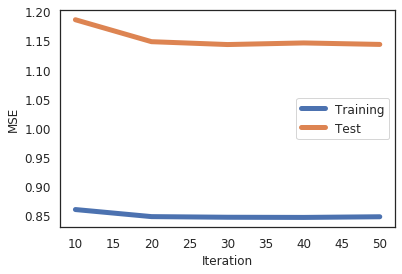

In [42]:
plt.plot([10,20,30,40,50], [get_mse(i,train_Ncore_user) for i in SGD_Pred1], \
             label = 'Training', linewidth=5)
plt.plot([10,20,30,40,50], [get_mse(i,test_Ncore_user) for i in SGD_Pred1], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('Iteration', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);



In [43]:
SGD2=[RecommendationSGD_Random(train_Ncore_user,max_iter = 20,n_factors = x,
                 batch_size=50) for x in [5,10,20,25,30]]



In [44]:
SGD_Pred2=[x.get_prediction() for x in SGD2]



1.3242599926172334
1.0951524876705845
1.0047846222385746
0.9583753117377342
0.930406959214402
0.9124826634994916
0.9006052180032111
0.8919170928555509
	current iteration: 10
0.8848952519386141
0.8797321024969896
0.8762227572558943
0.8723477504402563
0.8696955016402087
0.867172556383041
0.8658632562730623
0.8638259178802492
0.8624319053795714
0.8610234168679636
	current iteration: 20
0.8602863882567571
1.773628668012832
1.2304963452857611
1.0487643335318229
0.9663291042887289
0.9232155158269543
0.8984042001902546
0.8829972305711178
0.8720986692492435
	current iteration: 10
0.8657453395357236
0.8604109485431796
0.8566760729265388
0.8547285638793269
0.852737509742774
0.8508092058632462
0.8496820293265566
0.8488941528065141
0.8485302953399785
0.8473557246893811
	current iteration: 20
0.8473259591298574
2.752874870509485
1.4865656014607602
1.122607340792057
0.9774763715923419
0.9080263769552203
0.8724996627771555
0.852586037338427
0.8407600021318458
	current iteration: 10
0.8333768279478557

In [45]:
for i,v in enumerate([5,10,20,25,30]):
    print ("MSE on Training with ", v, " Latent Factors: ",get_mse(SGD_Pred2[i],train_Ncore_user))
    print ("MSE on Test with ", v, " Latent Factors: ",get_mse(SGD_Pred2[i],test_Ncore_user))



MSE on Training with  5  Latent Factors:  0.8597999838423942
MSE on Test with  5  Latent Factors:  1.1412346180978317
MSE on Training with  10  Latent Factors:  0.8473259591298574
MSE on Test with  10  Latent Factors:  1.1478538847594293
MSE on Training with  20  Latent Factors:  0.8248876101676886
MSE on Test with  20  Latent Factors:  1.1955672718925558
MSE on Training with  25  Latent Factors:  0.8188735769462382
MSE on Test with  25  Latent Factors:  1.1738201507148993
MSE on Training with  30  Latent Factors:  0.8103263023085251
MSE on Test with  30  Latent Factors:  1.1846210253343925


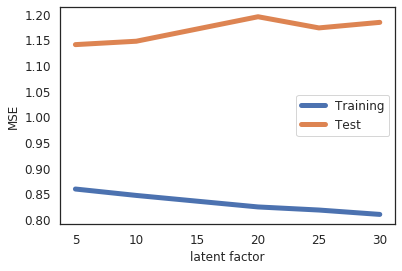

In [46]:
plt.plot([5,10,20,25,30], [get_mse(i,train_Ncore_user) for i in SGD_Pred2], \
             label = 'Training', linewidth=5)
plt.plot([5,10,20,25,30], [get_mse(i,test_Ncore_user) for i in SGD_Pred2], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('latent factor', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);



In [50]:
meta_original = getDF('/home/kapil/SJSU Acad/SJSU 2nd Sem/256 Wu/CMPE-256/E-commerce-recommedation-system/Data/meta_Beauty.json')


In [51]:
meta=copy.deepcopy(meta_original)
for i in range(4):
    meta['type_L'+str(i)] = meta['categories'].apply(lambda x: x[0][i] if i<len(x[0]) else np.nan)
item_category=pd.DataFrame(meta.groupby(['type_L0', 'type_L1', 'type_L2', 'type_L3'])['asin'].nunique()).reset_index()



In [52]:
meta.columns

Index(['asin', 'description', 'title', 'imUrl', 'salesRank', 'categories',
       'price', 'related', 'brand', 'type_L0', 'type_L1', 'type_L2',
       'type_L3'],
      dtype='object')

In [53]:
meta.groupby(['type_L0', 'type_L1', 'type_L2', 'type_L3']).asin.nunique().to_frame()



asin
type_L0                type_L1                     type_L2                    type_L3                   
Beauty                 Bath & Body                 Bath                       Bath Bombs             254
                                                                              Bath Pearls & Flakes    33
                                                                              Bubble Bath            516
                                                                              Minerals & Salts       791
                                                                              Oils                   295
...                                                                                                  ...
Health & Personal Care Personal Care               Lip Care                   Balms & Moisturizers     1
                       Stationery & Party Supplies Party Supplies             Decorations              1
                                                                              Favors                   1
Home & Kitchen         Kitchen & Dining            Home Brewing & Wine Making Beer Brewing             1
Sports & Outdoors      Fan Shop                    Bags, Packs & Accessories  Tote Bags                1

[172 rows x 1 columns]

In [61]:
def Advanced_Recommendation(Pred,ratings_Ncore,User,N):
    user_in_list=user_map_afterNcore.loc[user_map_afterNcore['reviewerID']==User,'reviewerID_Ncore']
    if pd.notnull(user_in_list.values[0]):
        Pred_C=copy.deepcopy(Pred)
        #replace all the item rated by users as zero to avoid recommend item user already bought
        Pred_C[np.where(ratings_Ncore!=0)[0],np.where(ratings_Ncore!=0)[1]]=0
        #find what the user has rated
        item_bought=np.nonzero(ratings_Ncore[int(user_in_list.values[0]),:])[0].tolist()
        asin_bought=item_map_afterNcore.loc[item_map_afterNcore['asinID_Ncore'].isin(item_bought),'asin'].tolist()
        category_bought=meta.loc[meta['asin'].isin(asin_bought),['type_L1','type_L2','type_L3','asin']]
        category_bought_df=category_bought.groupby(['type_L1','type_L2','type_L3'])['asin'].nunique().to_frame().reset_index()\
        .sort_values(by='asin',ascending=False)
        total=np.sum(category_bought_df['asin'])
        category_bought_df['precent']=category_bought_df['asin']/total
        category_bought_df['precent']=category_bought_df['precent'].apply(lambda x: "{0:.0%}".format(x))
        print ('items bought')
        print(category_bought_df[['type_L1','type_L2','type_L3','asin','precent']])
        #recommend items
        item_Ncore=np.argsort(Pred_C[int(user_in_list.values[0]),:])[:-N-1:-1].tolist()
        Recommend=item_map_afterNcore.loc[item_map_afterNcore['asinID_Ncore'].isin(item_Ncore),'asin'].tolist()
        print ("\n items recommended")
        return  meta.loc[meta['asin'].isin(Recommend),['asin','title','type_L1','type_L2','type_L3','description','imUrl']]
    else:
        print ('Too few items bought to predict')
        return False


In [62]:
Advanced_Recommendation(SGD_Pred2[0],ratings_Ncore,User='AZXP46IB63PU8',N=10)



items bought
       type_L1 type_L2                type_L3  asin precent
2    Skin Care    Face  Creams & Moisturizers     4     50%
1    Skin Care    Body           Moisturizers     2     25%
0  Bath & Body    Bath            Bubble Bath     1     12%
3    Skin Care    Face          Oils & Serums     1     12%

 items recommended


,asin,title,type_L1,type_L2,type_L3,description,imUrl
6285,B0002Q8W9I,NEW cnd Nail Design Stickey Base Coat 0.33Oz,Makeup,Nails,Top & Base Coats,A soft sticky base coat designed to anchor nai...,http://ecx.images-amazon.com/images/I/311RJ0WA...
41416,B000YT5NIG,"Biosilk Silk Therapy Hair Treatment, 34 Ounce",Skin Care,Body,Moisturizers,NaN,http://ecx.images-amazon.com/images/I/31jTmijK...
63126,B001H3JQ0E,X-Fusion Medium Brown 25 gram .87 Oz,Hair Care,Hair Loss Products,Styling Products,XFusion Hair Building Fibers instantly make th...,http://ecx.images-amazon.com/images/I/2182VwZr...
90717,B0030VT7XW,L.A. Colors Moisture Lipstick 136 Black Velvet,Makeup,Lips,Lipstick,L.A. Colors Moisture Lipstick 136 Black Velvet,http://ecx.images-amazon.com/images/I/11VdDpaT...
122585,B004HI5GOG,Anastasia Beverly Hills Beauty Express - Blonde,Makeup,Eyes,Eyebrow Color,Anastasia Beverly Hills Beauty Express for Bro...,http://ecx.images-amazon.com/images/I/51j9WvHv...
161858,B006UMU4NK,World Pride&reg; Acrylic UV Gel False Nail Tip...,Tools & Accessories,Nail Tools,Clippers & Trimmers,"-100% brand new, never been used\n-Suitable fo...",http://ecx.images-amazon.com/images/I/41levDSP...
165642,B007736X86,"OPI: Lacquer H62 Thanks a Windmillion Lacquer,...",Makeup,Nails,Nail Polish,Nothing completes a look more beautifully than...,http://ecx.images-amazon.com/images/I/51GqMq1D...
171231,B007OT1RIY,"Vidal Sassoon Medium Side Combs, Tortoise, 2 C...",Hair Care,Styling Tools,Styling Accessories,Medium Tortoise Tuck Combs hold hair firmly in...,http://ecx.images-amazon.com/images/I/41IgKcqz...
191098,B0092KGYEA,350buy Basic Acrylic 6 Powder Liquid KITS NAIL...,Tools & Accessories,Nail Tools,Nail Art Equipment,6 different colors acrylic powder with extra 1...,http://ecx.images-amazon.com/images/I/61TyLwgW...
193171,B009A9LBL4,CND Shellac French Manicure Kit Top Base Coat ...,Makeup,Nails,Nail Polish,A french manicure is the ultimate in class and...,http://ecx.images-amazon.com/images/I/41-1aPTg...


In [63]:
df.loc[df['reviewerID']=='AZXP46IB63PU8'].merge(meta, how='left',on='asin')[["reviewText","reviewerID",\
                                                                             "asin","overall","title",\
                                                                             "type_L1","type_L2","type_L3"]]



,reviewText,reviewerID,asin,overall,title,type_L1,type_L2,type_L3
0,I did 't have a reaction to this cream which i...,AZXP46IB63PU8,B0007W1R58,5.0,Olay Regenerist Night Recovery Cream 1.7 Oz,Skin Care,Body,Moisturizers
1,I purchased this because I bought the day crea...,AZXP46IB63PU8,B000KPO99I,5.0,"L'Oreal Paris Age Perfect Night Cream, 2.5 Flu...",Skin Care,Face,Creams & Moisturizers
2,I use this every day. It's a light face cream...,AZXP46IB63PU8,B000UVZU1S,5.0,"St. Ives Facial Moisturizer, Timeless Skin Col...",Skin Care,Face,Creams & Moisturizers
3,My face is very dry and flakey. This cream ke...,AZXP46IB63PU8,B0012J30LY,5.0,Regenerist Micro-Sculpting Cream 1.7 Oz,Skin Care,Face,Creams & Moisturizers
4,I have diabetic never pain and was looking for...,AZXP46IB63PU8,B0043494XS,5.0,"Conair Waterfall Foot Spa with Lights, Bubbles...",Bath & Body,Bath,Bubble Bath
5,Really great skin cream. I bought it because ...,AZXP46IB63PU8,B004YWRYUY,5.0,L'oreal Age Perfect Day Cream SPF 15 2.5 Oz,Skin Care,Face,Creams & Moisturizers
6,A really great skin fluid. I like it even mor...,AZXP46IB63PU8,B005H1541C,5.0,L'Oreal Paris Age Perfect Hydra-Nutrition Adva...,Skin Care,Face,Oils & Serums
7,"If you have dry skin for whatever reason, this...",AZXP46IB63PU8,B00AHH00TC,5.0,"Gold Bond Diabetic Skin Relief Lotion, 13 Ounce",Skin Care,Body,Moisturizers


In [64]:
meta.loc[meta['asin']=="B000F8FZAC",["title"]].values


array([['Moisturizer-Almond Aloe With SPF15 Earth Science 5 oz Cream']],
      dtype=object)